In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import math
import numpy as np
import json
import os
import cv2
from PIL import Image
import tensorflow as tf
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
import matplotlib.pyplot as plt
import pandas as pd
import gc
import itertools
from sklearn import metrics
from collections import Counter
from keras import backend as K
from tqdm import tqdm
import shutil
import glob

In [3]:
os.mkdir('augmented')
os.mkdir('augmented/benign')
os.mkdir('augmented/malignant')

In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [5]:
import itertools
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
%matplotlib inline

In [6]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

def processing2(img_path):
    img = cv2.imread(img_path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128,128))
    image = cv2.medianBlur(image, 5)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    cv2.imwrite(img_path,image)

In [ ]:
files_benign=getListOfFiles('/content/gdrive/MyDrive/BreakHis/1 Benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/benign')

In [ ]:
files_malignant=getListOfFiles('/content/gdrive/MyDrive/BreakHis/1 Malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/malignant')

In [ ]:
benign_train = np.array(Dataset_loader('augmented/benign',128))
malign_train = np.array(Dataset_loader('augmented/malignant',128))
benign_test = np.array(Dataset_loader('augmented/benign',128))
malign_test = np.array(Dataset_loader('augmented/malignant',128))

100%|██████████| 3451/3451 [00:58<00:00, 58.68it/s]


In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=11)

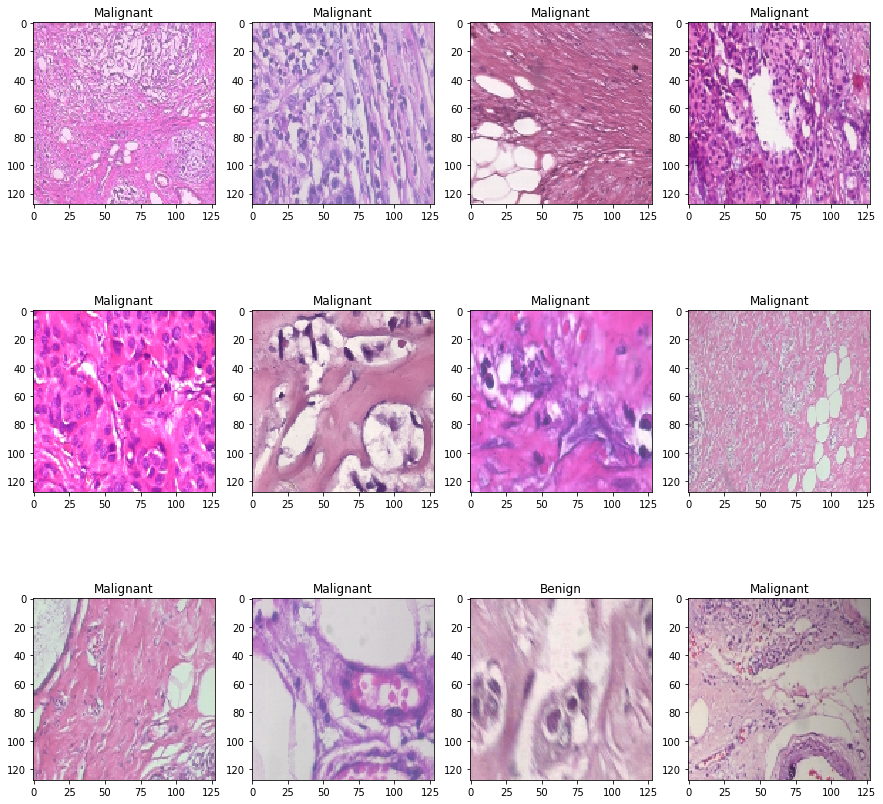

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
INPUT_SHAPE=(128,128,3)
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid',input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid',input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               7373056   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [ ]:
EPOCHS=100
train_images_scaled=X_train/255.
es_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
history=model.fit(train_images_scaled, Y_train, batch_size=32, callbacks=[es_callback], validation_split=0.1, epochs=EPOCHS, verbose=1)

Epoch 1/100
110/110 [==============================] - 46s 408ms/step - loss: 0.2786 - accuracy: 0.8864 - val_loss: 0.2438 - val_accuracy: 0.8590
Epoch 2/100
110/110 [==============================] - 45s 405ms/step - loss: 0.2380 - accuracy: 0.8876 - val_loss: 0.2539 - val_accuracy: 0.8590
Epoch 3/100
110/110 [==============================] - 45s 405ms/step - loss: 0.2174 - accuracy: 0.8956 - val_loss: 0.2440 - val_accuracy: 0.8667
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


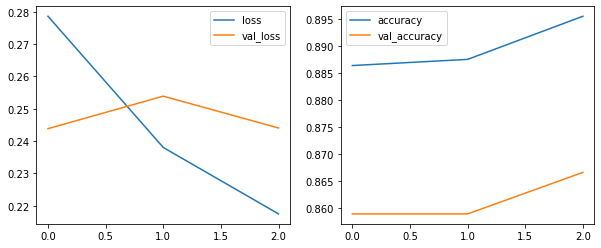

In [ ]:
import pandas as pd
fig, ax = plt.subplots(1,2,figsize=(10,4))
history_df=pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
X_test_scaled=x_val/255.
predictions=model.predict(X_test_scaled)
predictions[:5]

array([[6.2814248e-15, 1.0000000e+00],
       [2.1029262e-08, 1.0000000e+00],
       [1.3385177e-01, 8.6614829e-01],
       [2.1085531e-02, 9.7891450e-01],
       [5.1429711e-04, 9.9948573e-01]], dtype=float32)

In [ ]:
predictions_lables=np.argmax(predictions, axis=1)
predictions_lables[:5]

array([1, 1, 1, 1, 1])

In [ ]:
class_names={0:'Benign',1:'malignant'}

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_val, predictions_lables, target_names=class_names))
pd.DataFrame(confusion_matrix(y_val, predictions_lables), index=class_names, columns=class_names)

ValueError: ignored